In [285]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем библиотеку re для работы с регулярными выражениями:
import re

# Импортируем библиотеку category_encoders для кодирования признаков:
import category_encoders as ce

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [286]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [287]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [288]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
data_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
data_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# 1. Загрузка и знакомство с данными

In [289]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [290]:
data_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [291]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [292]:
data_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [293]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [294]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [295]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
data_train['sample'] = 1 # помечаем где у нас трейн
data_test['sample'] = 0 # помечаем где у нас тест
data_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([data_test, data_train], sort=False).reset_index(drop=True)# объединяем

In [296]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. Очистка данных

Выведем на экран названия столбцов, где число пропусков больше 0. 

In [297]:
cols_null_percent = hotels.isnull().mean() * 100
cols_null_count = hotels.isnull().sum()
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_null_count, cols_with_null)

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

lat    0.633655
lng    0.633655
dtype: float64

Отображение пропусков

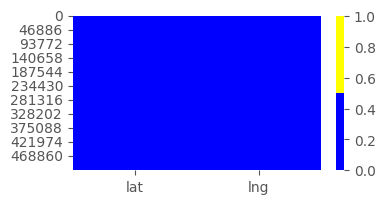

In [298]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(4, 2))
cols = cols_with_null.index
ax = sns.heatmap(
    hotels[cols].isnull(),
    cmap=sns.color_palette(colors),
)

На тепловой карте наблюдаются явные закономерности в пропусках данных. В частности, видно, что в случаях, когда отсутствует один из параметров lat или lng, другой также отсутствует, что выразилось совпадением жёлтых полос для этих признаков. Для упрощения дальнейшего анализа принято решение заменить все отсутствующие значения в этих колонках на 0.

In [299]:
hotels.fillna({'lat': 0, 'lng': 0}, inplace=True)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


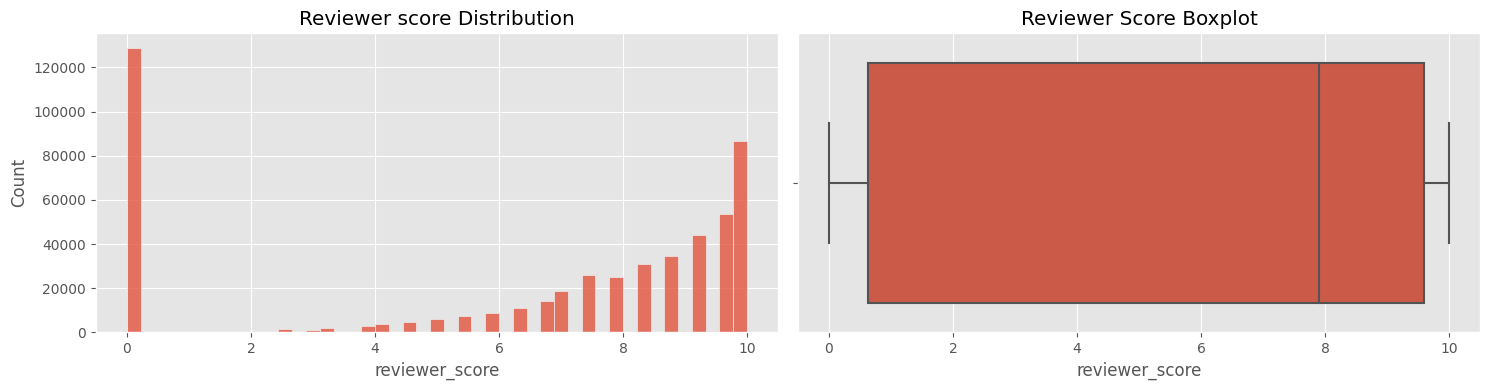

In [300]:
# Построим гистограмму и коробчатую диаграмму для признака (reviewer_score):
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Построим гистограмму для признака 'reviewer_score'
histplot = sns.histplot(data=hotels, x='reviewer_score', ax=axes[0])
histplot.set_title('Reviewer score Distribution')

# Построим коробчатую диаграмму для признака 'reviewer_score'
boxplot = sns.boxplot(data=hotels, x='reviewer_score', ax=axes[1])
boxplot.set_title('Reviewer Score Boxplot')

# Показать графики
plt.tight_layout()
plt.show()

Обнаружение и ликвидация дубликатов

In [301]:
dupl_columns = list(hotels.columns)

mask = hotels.duplicated(subset=dupl_columns)
hotels_duplicates = hotels[mask]

print(f'Число найденных дубликатов: {hotels_duplicates.shape[0]}')

hotels = hotels.drop_duplicates(subset=dupl_columns)

print(f'Результирующее число записей: {hotels.shape[0]}')

Число найденных дубликатов: 336
Результирующее число записей: 515402


ОБНАРУЖЕНИЕ И ЛИКВИДАЦИЯ НЕИНФОРМАТИВНЫХ ПРИЗНАКОВ

In [302]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in hotels.columns:
    #наибольшая относительная частота в признаке
    top_freq = hotels[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = hotels[col].nunique() / hotels[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

information_hotels = hotels.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_hotels.shape[1]}')

Результирующее число признаков: 18


# 3. Исследование признаков, извлечение полезной информации

# 3.1 Проектирование признаков

Найдем список уникальных городов

In [303]:
def hotel_city(hotel_address_lst):
    hotel_address_word = hotel_address_lst.split()
    city = hotel_address_word[-2]
    if city == "United":  
        city = hotel_address_word[-5]
    return city

hotels['hotel_city'] = hotels.apply(lambda x: hotel_city(x['hotel_address']), axis=1, result_type='expand')

hotels['hotel_city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

# На основе данных (дата, когда рецензент разместил соответствующий отзыв 'review_date') можим создать еще признаков когда иммено был розмещен отзыв такие как:

* Год ('review_year');
* Месяц ('review_month');
* День ('review_day');
* День Недели ('review_dayofweek');
* Извлечь номер недели года ('review_week').

In [304]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day
hotels['review_dayofweek'] = hotels['review_date'].dt.dayofweek
hotels['review_week'] = hotels['review_date'].dt.isocalendar().week.astype('int')


Преобразуем признак tags в список тэгов

In [305]:
import re

def clean_tags(tags):
    # Удаляем скобки и одиночные кавычки, затем делим строку на список
    return re.sub(r"[\[\]']", "", tags).split(', ')

hotels['tags'] = hotels['tags'].apply(clean_tags)


выберем топ 10 тэгов

In [306]:
top_of_tags = hotels['tags'].explode().value_counts().head(10).index

for tag in top_of_tags:
    hotels['tag_'+ tag] = hotels['tags'].apply(
        lambda x: 1 if tag in x else 0
    )
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515402 non-null  object        
 1   additional_number_of_scoring                515402 non-null  int64         
 2   review_date                                 515402 non-null  datetime64[ns]
 3   average_score                               515402 non-null  float64       
 4   hotel_name                                  515402 non-null  object        
 5   reviewer_nationality                        515402 non-null  object        
 6   negative_review                             515402 non-null  object        
 7   review_total_negative_word_counts           515402 non-null  int64         
 8   total_number_of_reviews                     515402 non-null  int64         
 9 

In [307]:
hotels.head(4)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tag_ Leisure trip,tag_ Submitted from a mobile device,tag_ Couple,tag_ Stayed 1 night,tag_ Stayed 2 nights,tag_ Solo traveler,tag_ Stayed 3 nights,tag_ Business trip,tag_ Group,tag_ Family with young children
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,0,1,0,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,1,0,0,1,0,0,0,0,1,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,1,0,1,0,1,0,1,0,0
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,1,0,1,1,0,0,0,0,0,0


# 3.2 Кодирование признаков

In [308]:
import category_encoders as ce

Кодируем признак города где расположен отель

In [309]:
hotels = pd.get_dummies(hotels, columns=['hotel_city'])

Кодируем признка национальности

In [310]:
hotels['reviewer_nationality'].nunique()

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)


Удаляем признаки типа object

In [311]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# hotels.drop('days_since_review_year ', axis = 1, inplace=True)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515402 non-null  int64         
 1   review_date                                 515402 non-null  datetime64[ns]
 2   average_score                               515402 non-null  float64       
 3   review_total_negative_word_counts           515402 non-null  int64         
 4   total_number_of_reviews                     515402 non-null  int64         
 5   review_total_positive_word_counts           515402 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515402 non-null  int64         
 7   lat                                         515402 non-null  float64       
 8   lng                                         515402 non-null  float64       
 9 

# 3.3 Построили тепловую матрицу для проверки корреляций

<Axes: >

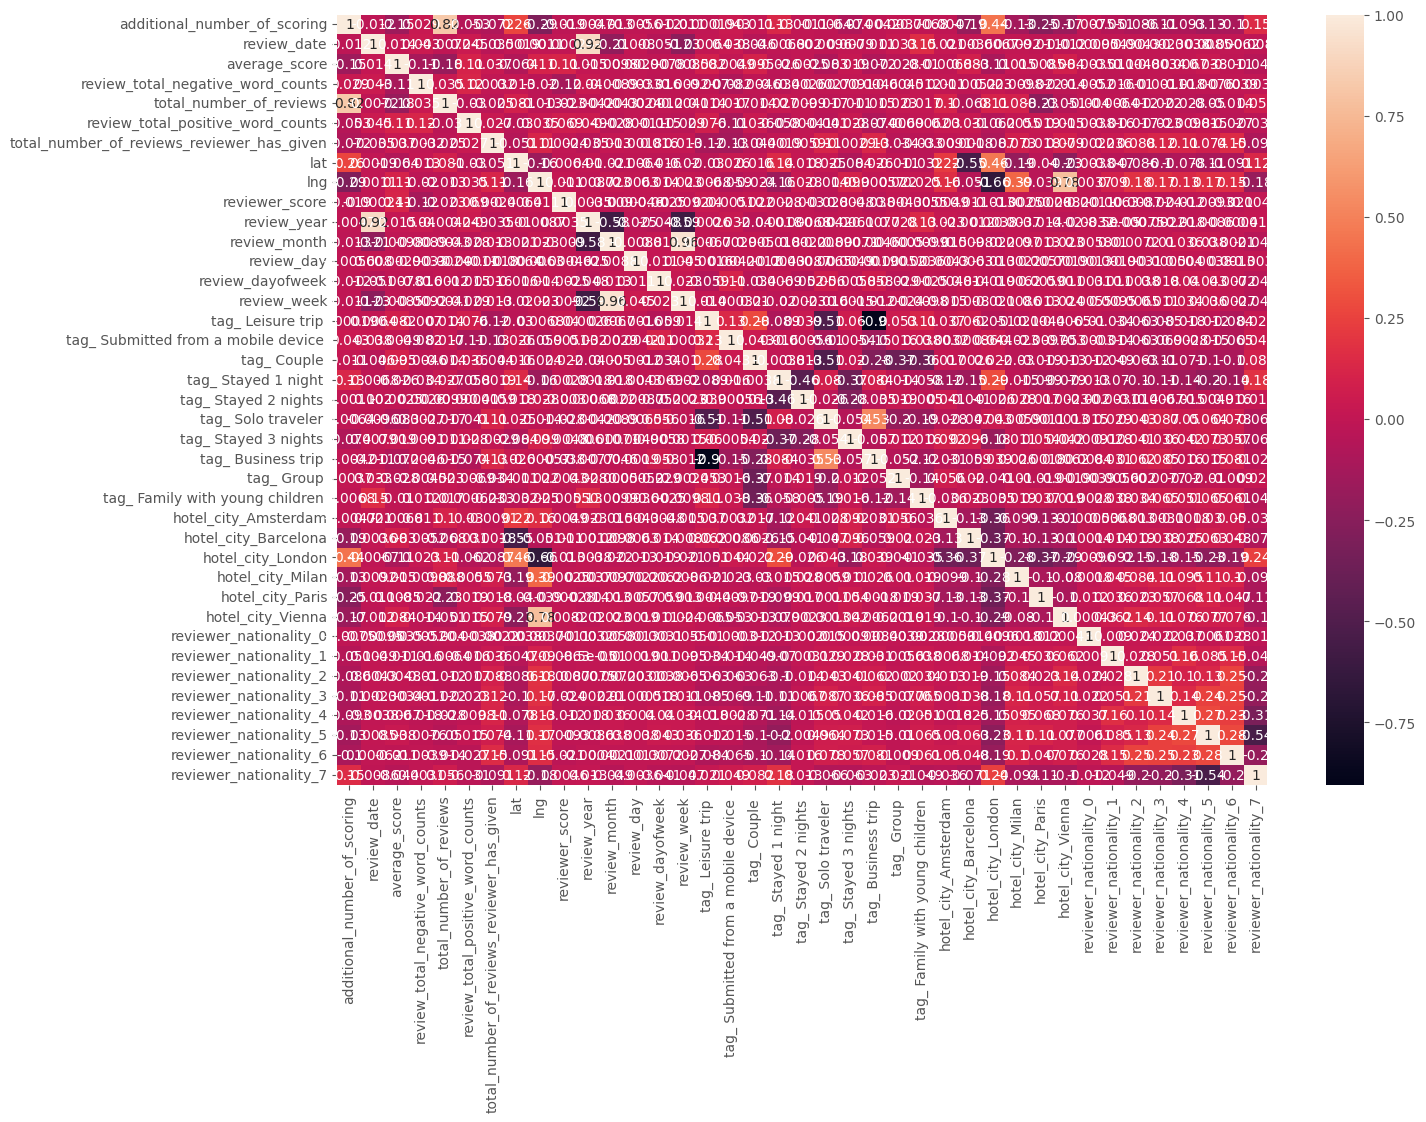

In [312]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

Тепловая матрица корреляций практически нечитаема из-за очень большого количества признаков. Попробуем отфильтровать только признаки с высокой корреляцией.

<Axes: >

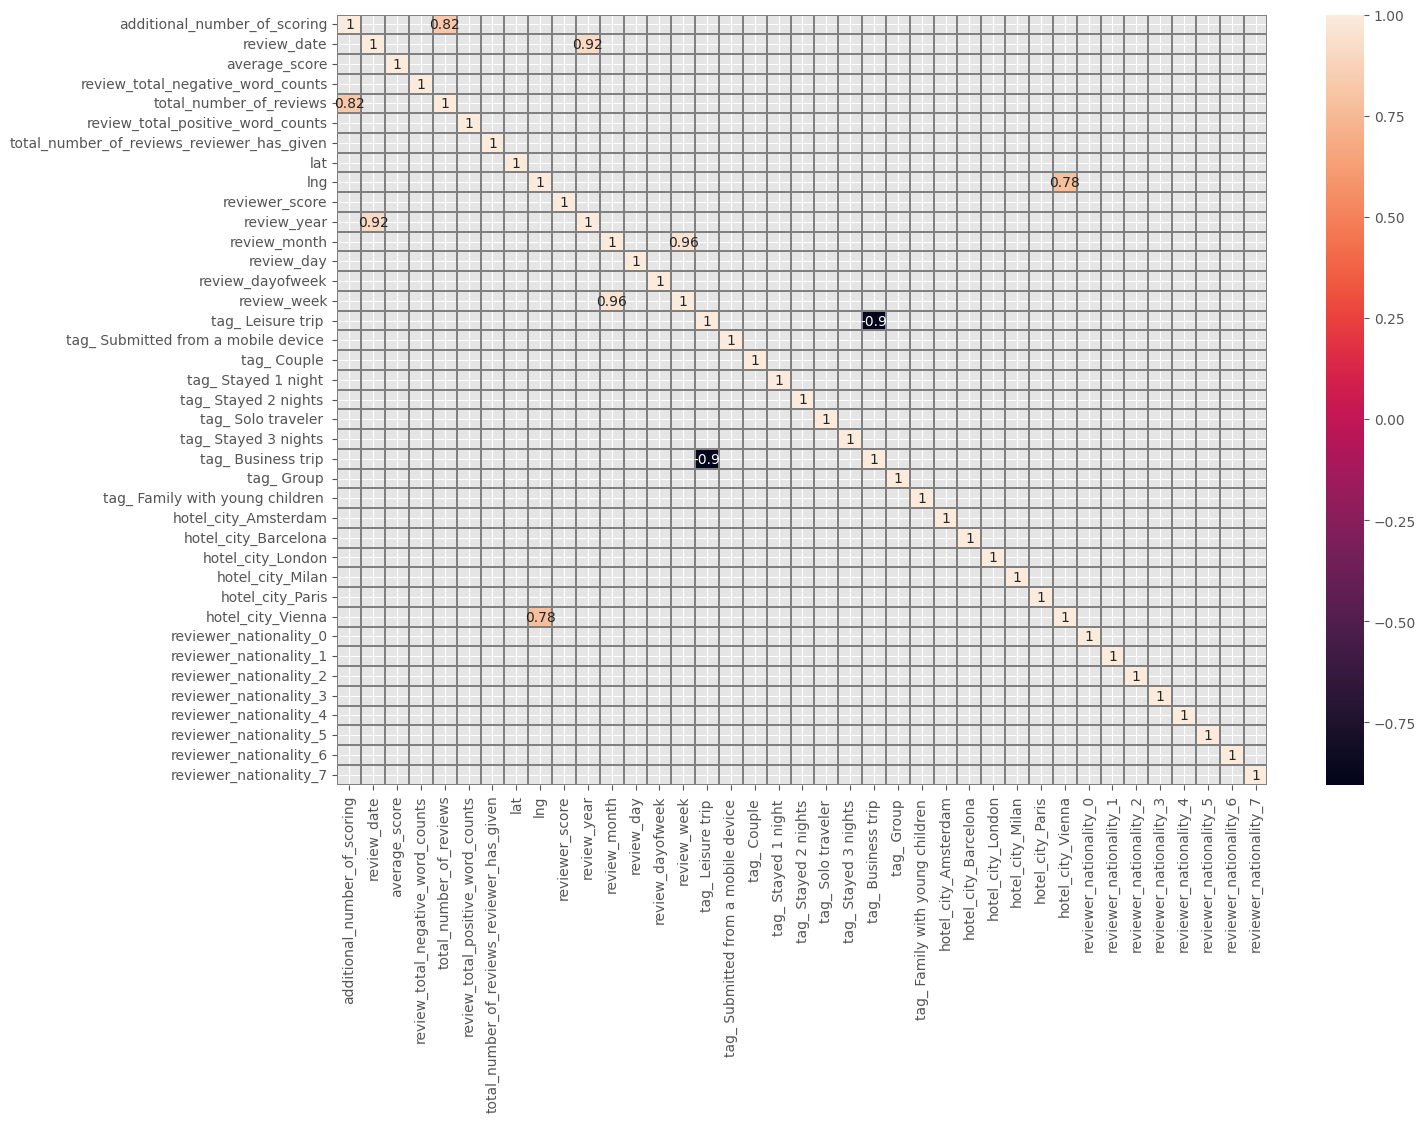

In [313]:
corr = hotels.drop(['sample'], axis=1).corr()
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(corr, mask=abs(corr) <= 0.7, linewidths=0.01, linecolor='gray', annot=True)

Видим, что некоторые признаки и  очень сильно коррелируют между собой. Фактически, они сообщают одну и ту же информацию. Оставим только один из них, а второй удалим.

In [314]:
hotels = hotels.drop(['additional_number_of_scoring','lng'], axis=1)

# 3.4 Проведём нормализацию распределений признаков, используя класс RobustScaler.

In [315]:
# для нормализации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

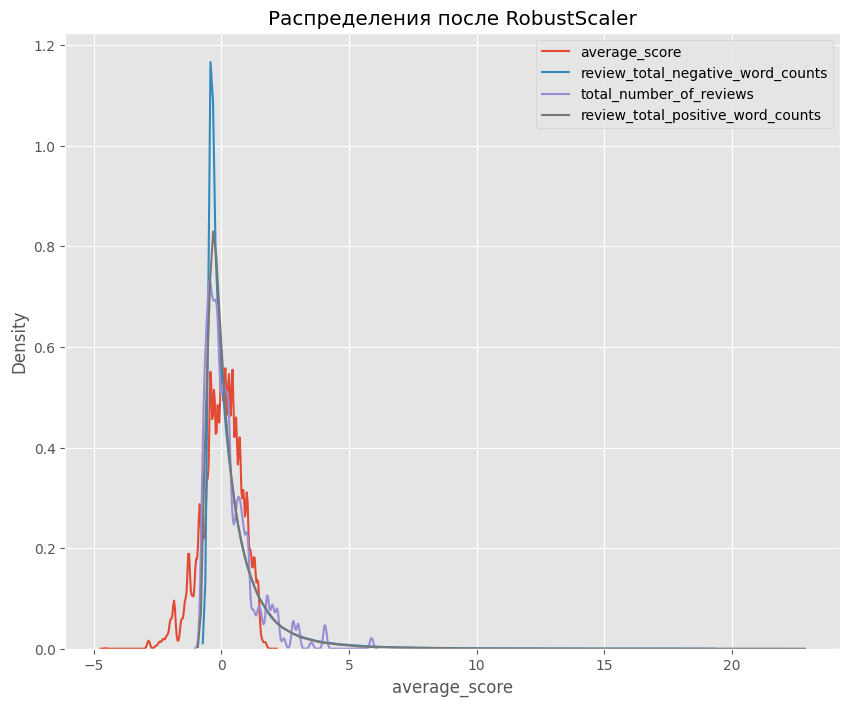

In [316]:
# Удаление нечисловых столбцов
hotels_numerical = hotels.select_dtypes(include=[np.number])

# Удаление строк с значениями NaN
# hotels_numerical = hotels_numerical.dropna()

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
hotels_r = r_scaler.fit_transform(hotels_numerical)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_r = pd.DataFrame(hotels_r, columns=hotels_numerical.columns)

# Визуализация распределений 
columns_to_plot = hotels_numerical.columns[:4]  # Используем первые 4 столбца для примера

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

for column in columns_to_plot:
    sns.kdeplot(hotels_r[column], ax=ax1, label=column)

ax1.legend()
plt.show()


In [317]:
hotels_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515402 non-null  float64
 1   review_total_negative_word_counts           515402 non-null  int64  
 2   total_number_of_reviews                     515402 non-null  int64  
 3   review_total_positive_word_counts           515402 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515402 non-null  int64  
 5   lat                                         515402 non-null  float64
 6   sample                                      515402 non-null  int64  
 7   reviewer_score                              515402 non-null  float64
 8   review_year                                 515402 non-null  int32  
 9   review_month                                515402 non-null  int32  
 10  r

# 4.Обучение модели

In [318]:
# Теперь выделим тестовую часть
train_data = hotels_numerical.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_numerical.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [319]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [320]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128906, 30), (386496, 30), (386496, 29), (309196, 29), (77300, 29))

In [321]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [322]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [323]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [324]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную ошибку (в процентах) предсказанных значений 
# от фактических
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9340534760364687


<Axes: >

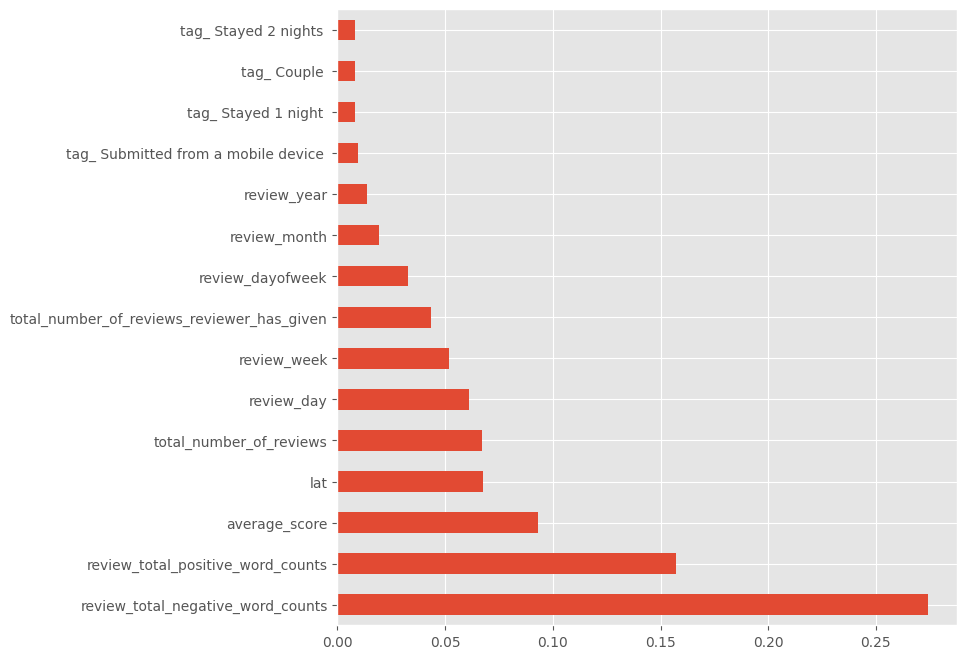

In [325]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (8,8)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [326]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,reviewer_score,review_year,review_month,review_day,...,tag_ Group,tag_ Family with young children,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
24297,8.4,0,2179,4,2,52.310118,0.0,2016,2,9,...,0,0,0,0,0,0,0,0,0,1
101348,8.7,13,12158,25,26,51.500961,0.0,2016,5,23,...,0,0,0,0,0,0,0,1,0,0
43591,9.0,0,707,12,2,48.886563,0.0,2016,7,25,...,0,0,0,0,0,0,0,0,0,1
10464,7.3,67,2215,12,5,51.512745,0.0,2016,3,3,...,0,0,0,0,0,0,0,0,0,1
58985,7.7,0,1573,9,1,51.490749,0.0,2015,12,11,...,0,0,0,0,0,1,0,1,0,0
1927,8.2,26,1718,87,2,45.465957,0.0,2017,6,25,...,0,0,0,0,0,0,0,0,0,1
44268,7.1,14,9086,11,5,51.501910,0.0,2016,11,19,...,0,1,0,0,0,0,0,0,0,1
21216,8.1,9,2312,8,10,51.526385,0.0,2017,5,14,...,0,0,0,0,0,0,1,1,1,0
15371,8.0,2,2491,4,2,51.556155,0.0,2016,3,1,...,0,0,0,0,0,0,0,0,0,1
72109,8.0,38,3150,0,2,51.522622,0.0,2016,2,2,...,0,0,0,0,0,0,0,0,0,1


In [327]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [328]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [329]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [330]:
predict_submission

array([8.574, 7.134, 8.182, ..., 7.755, 9.448, 7.472])

In [331]:
list(sample_submission)

['reviewer_score', 'id']

In [340]:
import numpy as np
import pandas as pd

# Проверка длины массива
print(len(predict_submission))  # Ожидается 128906
print(len(sample_submission))   # Ожидается 128935

# Пример усечения для иллюстрации
if len(predict_submission) > len(sample_submission):
    predict_submission = predict_submission[:len(sample_submission)]
elif len(predict_submission) < len(sample_submission):
    sample_submission = sample_submission.iloc[:len(predict_submission)]

# Назначьте столбец 'reviewer_score'
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)



#sample_submission['reviewer_score'] = predict_submission
#sample_submission.to_csv('submission.csv', index=False)
#sample_submission.head(10)

128935
128935


,reviewer_score
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
